The problem with my w(\theta) calculation appears to be fairly fundamental: calculating in a snapshot just gives very strange answers. I'm gonna try directly integratng the 3-d correlation function. I'm gonna try doing that directly, but it is possible that I'll have to emulate to get that quite right. 

There is a prefactor which I'm going to compute directly from the redMagic data that I have. 

In [1]:
from pearce.mocks import cat_dict
import numpy as np
from os import path
from astropy.io import fits
from astropy import constants as const, units as unit

In [2]:
import george
from george.kernels import ExpSquaredKernel

In [3]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

Load up the tptY3 buzzard mocks. 

In [4]:
fname = '/u/ki/jderose/public_html/bcc/measurement/y3/3x2pt/buzzard/flock/buzzard-2/tpt_Y3_v0.fits'
hdulist = fits.open(fname)

In [5]:
z_bins = np.array([0.15, 0.3, 0.45, 0.6, 0.75, 0.9])
zbin=1

In [6]:
a = 0.81120
z = 1.0/a - 1.0

Load up a snapshot at a redshift near the center of this bin. 

In [7]:
print z

0.232741617357


This code load a particular snapshot and and a particular HOD model. In this case, 'redMagic' is the Zheng07 HOD with the f_c variable added in.

In [8]:
cosmo_params = {'simname':'chinchilla', 'Lbox':400.0, 'scale_factors':[a]}
cat = cat_dict[cosmo_params['simname']](**cosmo_params)#construct the specified catalog!

cat.load_catalog(a)
#cat.h = 1.0
#halo_masses = cat.halocat.halo_table['halo_mvir']

In [9]:
cat.load_model(a, 'redMagic')

In [10]:
hdulist.info()

Filename: /u/ki/jderose/public_html/bcc/measurement/y3/3x2pt/buzzard/flock/buzzard-2/tpt_Y3_v0.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU       4   ()      
  1  xip         BinTableHDU     32   200R x 5C   [K, K, K, D, D]   
  2  xim         BinTableHDU     32   200R x 5C   [K, K, K, D, D]   
  3  gammat      BinTableHDU     32   400R x 5C   [K, K, K, D, D]   
  4  wtheta      BinTableHDU     32   300R x 5C   [K, K, K, D, D]   
  5  nz_shear_bpz  BinTableHDU     32   250R x 7C   [D, D, D, D, D, D, D]   
  6  nz_shear_true  BinTableHDU     32   250R x 7C   [D, D, D, D, D, D, D]   
  7  nz_pos_zrm  BinTableHDU     31   400R x 8C   [D, D, D, D, D, D, D, D]   
  8  nz_pos_zspec  BinTableHDU     31   400R x 8C   [D, D, D, D, D, D, D, D]   


Take the zspec in our selected zbin to calculate the dN/dz distribution. The below cell calculate the redshift distribution prefactor

$$ W = \frac{2}{c}\int_0^{\infty} dz H(z) \left(\frac{dN}{dz} \right)^2 $$

In [12]:
nz_zspec = hdulist[8]
#N = 0#np.zeros((5,))
N_total =  np.sum([row[2+zbin] for row in nz_zspec.data])
dNdzs = [] 
zs = []
W = 0 
for row in nz_zspec.data:

    N = row[2+zbin]
    
    dN = N*1.0/N_total
    
    #volIn, volOut = cat.cosmology.comoving_volume(row[0]), cat.cosmology.comoving_volume(row[2])

    #fullsky_volume = volOut-volIn
    #survey_volume = fullsky_volume*area/full_sky
    #nd = dN/survey_volume
    
    dz = row[2] - row[0]
    
    #print row[2], row[0]
    dNdz = dN/dz
        
    H = cat.cosmology.H(row[1])
        
    W+= dz*H*(dNdz)**2
    
    dNdzs.append(dNdz)
    zs.append(row[1])
    
    
    #for idx, n in enumerate(row[3:]):
    #    N[idx]+=n
W = 2*W/const.c

print W

2.75848072207e-06 km / (m Mpc)


(0, 1.0)

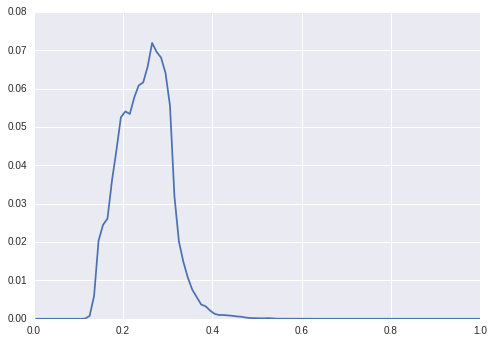

In [13]:
N_z = [row[2+zbin] for row in nz_zspec.data]
N_total =  np.sum(N_z)#*0.01
plt.plot(zs,N_z/N_total)
plt.xlim(0,1.0)

In [14]:
len(dNdzs)

400

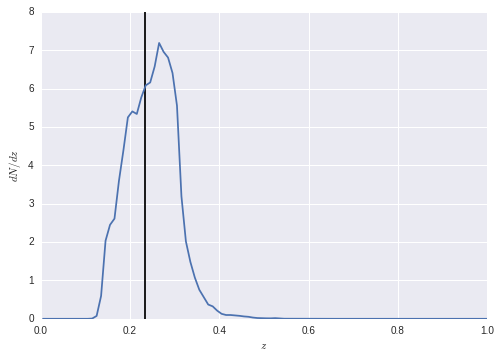

In [15]:
plt.plot(zs, dNdzs)
plt.vlines(z, 0,8)
plt.xlim(0,1.0)
plt.xlabel(r'$z$')
plt.ylabel(r'$dN/dz$')

In [16]:
len(nz_zspec.data)

400

In [17]:
np.sum(dNdzs)

100.0

In [18]:
np.sum(dNdzs)/len(nz_zspec.data)

0.25

In [19]:
W.to(1/unit.Mpc)

<Quantity 0.0027584807220739026 1 / Mpc>

If we happened to choose a model with assembly bias, set it to 0. Leave all parameters as their defaults, for now. 

In [20]:
4.51077317e-03

0.00451077317

In [71]:
params = cat.model.param_dict.copy()
#params['mean_occupation_centrals_assembias_param1'] = 0.0
#params['mean_occupation_satellites_assembias_param1'] = 0.0
params['logMmin'] = 13.4
params['sigma_logM'] = 0.1
params['f_c'] = 0.19
params['alpha'] = 1.0
params['logM1'] = 14.0
params['logM0'] = 12.0

print params

{'logM1': 14.0, 'logMmin': 13.4, 'f_c': 0.19, 'logM0': 12.0, 'sigma_logM': 0.1, 'alpha': 1.0}


In [72]:
cat.populate(params)

In [73]:
nd_cat =  cat.calc_analytic_nd()
print nd_cat

0.000298413920821


In [74]:
area = 5063 #sq degrees
full_sky = 41253 #sq degrees

volIn, volOut = cat.cosmology.comoving_volume(z_bins[zbin-1]), cat.cosmology.comoving_volume(z_bins[zbin])

fullsky_volume = volOut-volIn
survey_volume = fullsky_volume*area/full_sky
nd_mock = N_total/survey_volume
print nd_mock

0.000284539736705 1 / Mpc3


In [75]:
nd_mock.value/nd_cat

0.95350691389406483

In [76]:
#compute the mean mass
mf = cat.calc_mf()
HOD = cat.calc_hod()
mass_bin_range = (9,16)
mass_bin_size = 0.01
mass_bins = np.logspace(mass_bin_range[0], mass_bin_range[1], int( (mass_bin_range[1]-mass_bin_range[0])/mass_bin_size )+1 )

mean_host_mass = np.sum([mass_bin_size*mf[i]*HOD[i]*(mass_bins[i]+mass_bins[i+1])/2 for i in xrange(len(mass_bins)-1)])/\
                    np.sum([mass_bin_size*mf[i]*HOD[i] for i in xrange(len(mass_bins)-1)])
print mean_host_mass

1.25501362409e+14


In [77]:
10**0.35

2.2387211385683394

In [78]:
N_total

216485.0

In [79]:
theta_bins = np.logspace(np.log10(0.004), 0, 24)#/60
tpoints = (theta_bins[1:]+theta_bins[:-1])/2

In [80]:
r_bins = np.logspace(-0.5, 1.7, 16)
rpoints = (r_bins[1:]+r_bins[:-1])/2

Use my code's wrapper for halotools' xi calculator. Full source code can be found [here](https://github.com/mclaughlin6464/pearce/blob/31e2f6a3598217dcf1be3d2606b69c4e529fc791/pearce/mocks/cat.py#L688).

In [81]:
xi = cat.calc_xi(r_bins, do_jackknife=False)

Interpolate with a Gaussian process. May want to do something else "at scale", but this is quick for now. 

In [82]:
kernel = ExpSquaredKernel(0.05)
gp = george.GP(kernel)
gp.compute(np.log10(rpoints))

In [83]:
print xi

[  2.77290197e+03   1.23445025e+03   4.52855941e+02   1.36676697e+02
   4.17799037e+01   1.33224893e+01   6.03914557e+00   4.00023731e+00
   2.46529738e+00   1.28798814e+00   6.97832647e-01   3.64135260e-01
   1.40528253e-01   7.25355500e-02   2.69993333e-02]


In [84]:
xi[xi<=0] = 1e-2 #ack

In [85]:
from scipy.stats import linregress
m,b,_,_,_ = linregress(np.log10(rpoints), np.log10(xi))

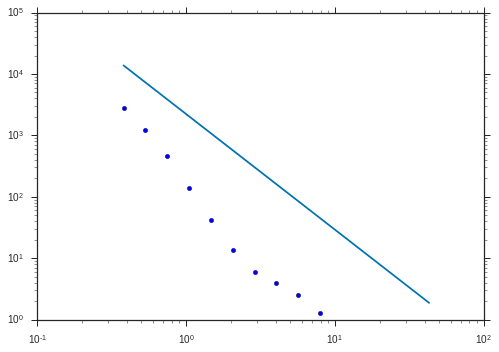

In [86]:
plt.plot(rpoints, (2.22353827e+03)*(rpoints**(-1.88359)))
#plt.plot(rpoints, b2*(rpoints**m2))

plt.scatter(rpoints, xi)
plt.loglog();

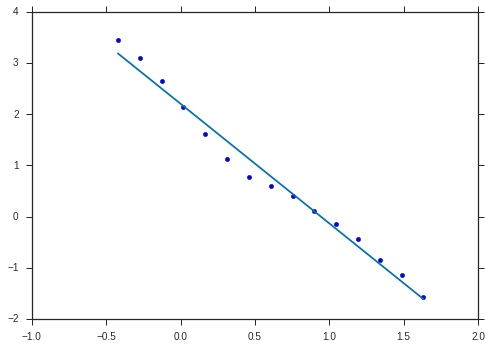

In [87]:
plt.plot(np.log10(rpoints), b+(np.log10(rpoints)*m))
#plt.plot(np.log10(rpoints), b2+(np.log10(rpoints)*m2))
#plt.plot(np.log10(rpoints), 90+(np.log10(rpoints)*(-2)))

plt.scatter(np.log10(rpoints), np.log10(xi) )
#plt.loglog();

In [88]:
print m,b

-2.33901178197 2.20456315116


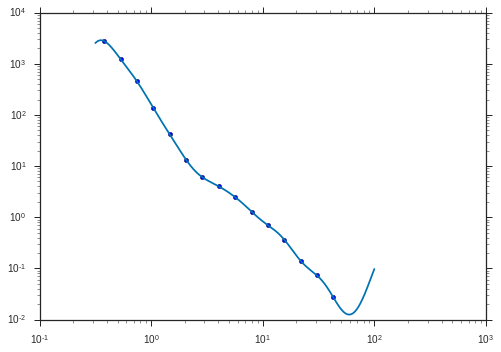

In [89]:
rpoints_dense = np.logspace(-0.5, 2, 500)

plt.scatter(rpoints, xi)
plt.plot(rpoints_dense, np.power(10, gp.predict(np.log10(xi), np.log10(rpoints_dense))[0]))
plt.loglog();

This plot looks bad on large scales. I will need to implement a linear bias model for larger scales; however I believe this is not the cause of this issue. The overly large correlation function at large scales if anything should increase w(theta). 

This plot shows the regimes of concern. The black lines show the value of r for u=0 in the below integral for each theta bin. The red lines show the maximum value of r for the integral I'm performing.

In [90]:
theta_bins_rm = np.logspace(np.log10(2.5), np.log10(250), 21)/60 #binning used in buzzard mocks
tpoints_rm = (theta_bins_rm[1:]+theta_bins_rm[:-1])/2.0

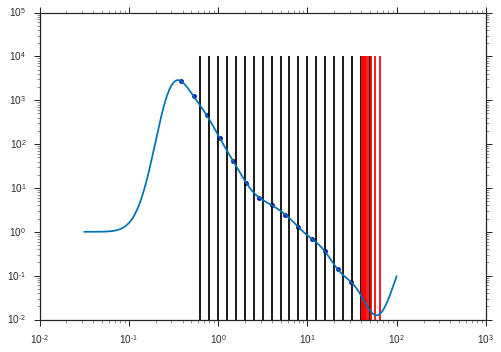

In [91]:
rpoints_dense = np.logspace(-1.5, 2, 500)
x = cat.cosmology.comoving_distance(z)

plt.scatter(rpoints, xi)
plt.plot(rpoints_dense, np.power(10, gp.predict(np.log10(xi), np.log10(rpoints_dense))[0]))
plt.vlines((a*x*np.radians(tpoints_rm)).value, 1e-2, 1e4)
plt.vlines((a*np.sqrt(x**2*np.radians(tpoints_rm)**2+unit.Mpc*unit.Mpc*10**(1.7*2))).value, 1e-2, 1e4, color = 'r')

plt.loglog();

Perform the below integral in each theta bin:

$$ w(\theta) = W \int_0^\infty du \xi \left(r = \sqrt{u^2 + \bar{x}^2(z)\theta^2} \right) $$

Where $\bar{x}$ is the median comoving distance to z. 

In [92]:
x = cat.cosmology.comoving_distance(z)
print x

944.909402664 Mpc


In [93]:
wt = np.zeros_like(tpoints_rm)
x = cat.cosmology.comoving_distance(z)*a
#ubins = np.linspace(10**-6, 10**2.0, 1001)
ubins = np.logspace(-6, 2.0, 101)

ubc = (ubins[1:]+ubins[:-1])/2.0
for bin_no, t_med in enumerate(np.radians(tpoints_rm)):
    int_xi = 0
    for ubin_no, _u in enumerate(ubc):
        _du = ubins[ubin_no+1]-ubins[ubin_no]
        u = _u*unit.Mpc*a
        du = _du*unit.Mpc*a
        #print np.sqrt(u**2+(x*t_med)**2)
        r = np.sqrt((u**2+(x*t_med)**2))#*cat.h#not sure about the h
        if r > unit.Mpc*10**1.7: #ignore large scales. In the full implementation this will be a transition to a bias model. 
            int_xi+=du*0
        else:
            # the GP predicts in log, so i predict in log and re-exponate
            int_xi+=du*(np.power(10, \
                    gp.predict(np.log10(xi), np.log10(r.value), mean_only=True)[0]))
        #int_xi+=du*(10**b)*(r.to("Mpc").value**m)
    
    #print (((int_xi*W))/wt_redmagic[0]).to("m/m")
    wt[bin_no] = int_xi*W.to("1/Mpc")

In [94]:
np.radians(tpoints_rm)

array([ 0.00082137,  0.00103404,  0.00130178,  0.00163885,  0.00206318,
        0.0025974 ,  0.00326993,  0.00411659,  0.00518248,  0.00652436,
        0.00821368,  0.01034042,  0.01301781,  0.01638846,  0.02063184,
        0.02597395,  0.03269927,  0.04116594,  0.05182485,  0.06524362])

In [95]:
#a subset of the data from above. I've verified it's correct, but we can look again. 
wt_redmagic = np.loadtxt('/u/ki/swmclau2/Git/pearce/bin/mcmc/buzzard2_wt_%d%d.npy'%(zbin,zbin))

In [96]:
tpoints_rm

array([ 0.04706095,  0.05924622,  0.07458657,  0.09389893,  0.11821175,
        0.14881978,  0.187353  ,  0.23586345,  0.2969345 ,  0.37381838,
        0.47060946,  0.59246221,  0.74586573,  0.93898932,  1.18211752,
        1.48819778,  1.87353001,  2.35863454,  2.96934496,  3.73818382])

In [97]:
mathematica_calc = np.array([122.444, 94.8279, 73.4406, 56.8769, 44.049, 34.1143, 26.4202, \
20.4614, 15.8466, 12.2726, 9.50465, 7.36099, 5.70081, 4.41506, \
3.41929, 2.64811, 2.05086, 1.58831, 1.23009, 0.952656])#*W

The below plot shows the problem. There appears to be a constant multiplicative offset between the redmagic calculation and the one we just performed. The plot below it shows their ratio. It is near-constant, but there is some small radial trend. Whether or not it is significant is tough to say. 

In [98]:
print W.value
print W.to("1/Mpc").value
print W.value

2.75848072207e-06
0.00275848072207
2.75848072207e-06


In [99]:
from scipy.special import gamma
def wt_analytic(m,b,t,x):
    return W.to("1/Mpc").value*b*np.sqrt(np.pi)*(t*x)**(1 + m)*(gamma(-(1./2) - m/2.)/(2*gamma(-(m/2.))) )

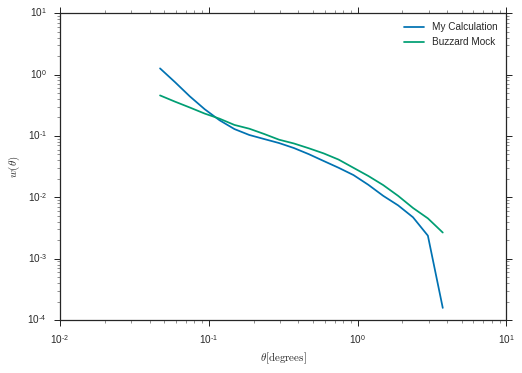

In [100]:
plt.plot(tpoints_rm, wt, label = 'My Calculation')
plt.plot(tpoints_rm, wt_redmagic, label = 'Buzzard Mock')
#plt.plot(tpoints_rm, W.to("1/Mpc").value*mathematica_calc, label = 'Mathematica Calc')
#plt.plot(tpoints_rm, wt_analytic(m,10**b, np.radians(tpoints_rm), x),label = 'Mathematica Calc' )

plt.ylabel(r'$w(\theta)$')
plt.xlabel(r'$\theta \mathrm{[degrees]}$')
plt.loglog();
plt.legend(loc='best')

In [101]:
wt_redmagic/(W.to("1/Mpc").value*mathematica_calc)

array([ 1.35290816,  1.3844851 ,  1.43353228,  1.47350073,  1.57193588,
        1.60464568,  1.79861938,  1.90448271,  1.98571283,  2.22377332,
        2.39953482,  2.55558267,  2.61706656,  2.48244942,  2.35738659,
        2.16215169,  1.8665413 ,  1.52976599,  1.33767384,  1.01438436])

In [102]:
import cPickle as pickle
with open('/u/ki/jderose/ki23/bigbrother-addgals/bbout/buzzard-flock/buzzard-0/buzzard0_lb1050_xigg_ministry.pkl') as f:
    xi_rm = pickle.load(f)

In [103]:
xi_rm.metrics[0].xi.shape

(15, 3, 3, 1)

In [104]:
xi_rm.metrics[0].mbins

array([-23, -22, -21, -20])

In [105]:
xi_rm.metrics[0].cbins

array([ 0.25,  0.5 ,  0.75,  1.  ])

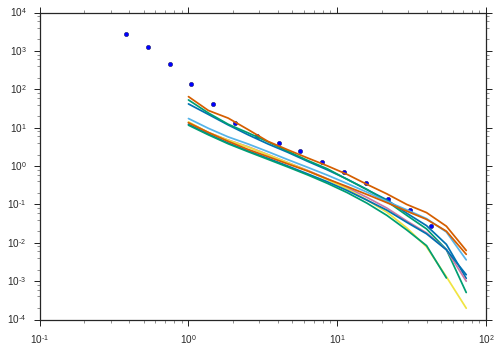

In [106]:
#plt.plot(np.log10(rpoints), b2+(np.log10(rpoints)*m2))
#plt.plot(np.log10(rpoints), 90+(np.log10(rpoints)*(-2)))

plt.scatter(rpoints, xi)
for i in xrange(3):
    for j in xrange(3):
        plt.plot(xi_rm.metrics[0].rbins[:-1], xi_rm.metrics[0].xi[:,i,j,0])
plt.loglog();

(2.0, 4)

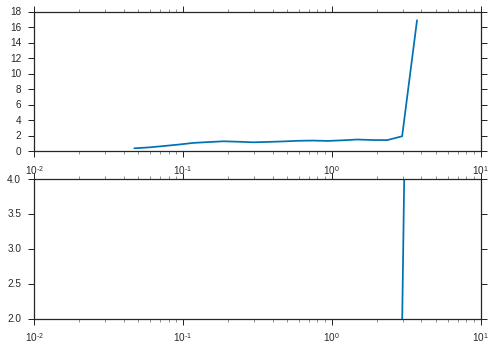

In [107]:
plt.subplot(211)
plt.plot(tpoints_rm, wt_redmagic/wt)
plt.xscale('log')
#plt.ylim([0,10])
plt.subplot(212)
plt.plot(tpoints_rm, wt_redmagic/wt)
plt.xscale('log')
plt.ylim([2.0,4])

In [268]:
xi_rm.metrics[0].xi.shape

(15, 3, 3, 1)

In [269]:
xi_rm.metrics[0].rbins #Mpc/h

array([   1.        ,    1.35935639,    1.8478498 ,    2.51188643,
          3.41454887,    4.64158883,    6.30957344,    8.57695899,
         11.65914401,   15.84893192,   21.5443469 ,   29.28644565,
         39.81071706,   54.11695265,   73.56422545,  100.        ])

The below cell calculates the integrals jointly instead of separately. It doesn't change the results significantly, but is quite slow. I've disabled it for that reason. 

In [101]:
x = cat.cosmology.comoving_distance(z)*a
#ubins = np.linspace(10**-6, 10**2.0, 1001)
ubins = np.logspace(-6, 2.0, 51)
ubc = (ubins[1:]+ubins[:-1])/2.0

#NLL
def liklihood(params, wt_redmagic,x, tpoints):
    #print _params
    #prior  = np.array([ PRIORS[pname][0] < v < PRIORS[pname][1] for v,pname in zip(_params, param_names)])
    #print param_names
    #print prior
    #if not np.all(prior):
    #    return 1e9
    #params = {p:v for p,v in zip(param_names, _params)}
    #cat.populate(params)
    #nd_cat =  cat.calc_analytic_nd(parmas)
    #wt = np.zeros_like(tpoints_rm[:-5])
    
    #xi = cat.calc_xi(r_bins, do_jackknife=False)
    #m,b,_,_,_ = linregress(np.log10(rpoints), np.log10(xi))
    
    #if np.any(xi < 0):
    #    return 1e9
    #kernel = ExpSquaredKernel(0.05)
    #gp = george.GP(kernel)
    #gp.compute(np.log10(rpoints))
    
    #for bin_no, t_med in enumerate(np.radians(tpoints_rm[:-5])):
    #    int_xi = 0
    #    for ubin_no, _u in enumerate(ubc):
    #        _du = ubins[ubin_no+1]-ubins[ubin_no]
    #        u = _u*unit.Mpc*a
    #        du = _du*unit.Mpc*a
            #print np.sqrt(u**2+(x*t_med)**2)
    #        r = np.sqrt((u**2+(x*t_med)**2))#*cat.h#not sure about the h
            #if r > unit.Mpc*10**1.7: #ignore large scales. In the full implementation this will be a transition to a bias model. 
            #    int_xi+=du*0
            #else:
                # the GP predicts in log, so i predict in log and re-exponate
            #    int_xi+=du*(np.power(10, \
            #            gp.predict(np.log10(xi), np.log10(r.value), mean_only=True)[0]))
    #        int_xi+=du*(10**b)*(r.to("Mpc").value**m)

        #print (((int_xi*W))/wt_redmagic[0]).to("m/m")
        #break
    #    wt[bin_no] = int_xi*W.to("1/Mpc")
        
    wt = wt_analytic(params[0],params[1], tpoints, x.to("Mpc").value)   
    chi2 = np.sum(((wt - wt_redmagic[:-5])**2)/(1e-3*wt_redmagic[:-5]) )
    
    #chi2=0
    #print nd_cat
    #print wt
    #chi2+= ((nd_cat-nd_mock.value)**2)/(1e-6)
    
    #mf = cat.calc_mf()
    #HOD = cat.calc_hod()
    #mass_bin_range = (9,16)
    #mass_bin_size = 0.01
    #mass_bins = np.logspace(mass_bin_range[0], mass_bin_range[1], int( (mass_bin_range[1]-mass_bin_range[0])/mass_bin_size )+1 )

    #mean_host_mass = np.sum([mass_bin_size*mf[i]*HOD[i]*(mass_bins[i]+mass_bins[i+1])/2 for i in xrange(len(mass_bins)-1)])/\
    #                    np.sum([mass_bin_size*mf[i]*HOD[i] for i in xrange(len(mass_bins)-1)])
        
    #chi2+=((13.35-np.log10(mean_host_mass))**2)/(0.2)
    print chi2
    return chi2 #nll

In [102]:
print nd_mock
print wt_redmagic[:-5]

0.000284539736705 1 / Mpc3
[ 0.45695747  0.36215491  0.29041139  0.23118318  0.19100328  0.151003
  0.13108268  0.10749353  0.08680055  0.07528302  0.06291195  0.05189149
  0.04115488  0.0302334   0.02223498]


In [103]:
import scipy.optimize as op

In [104]:
results = op.minimize(liklihood, np.array([-2.2, 10**1.7]),(wt_redmagic,x, tpoints_rm[:-5]))

2270.69059046
2270.69058895
2270.69059046
2270.69059046
7841.38974739
7841.38974739
7841.39300074
7841.38975346
2181.07354768
2181.07354768
2181.0735391
2181.07354764
1154.09169098
1154.09169098
1154.0916066
1154.09169071
624.975420537
624.975420537
624.975486722
624.975420622
719.728383515
719.728383515
719.728308654
719.728383274
590.593769294
590.593769294
590.593767007
590.593769223
590.536558153
590.536558153
590.536558196
590.536558088
12955.9681198
12955.9681198
12955.9734287
12955.9681287
682.478329307
682.478329307
682.478450165
682.47832951
590.500444955
590.500444955
590.500446681
590.500444893
590.427506984
590.427506984
590.42750871
590.427506923
590.135964791
590.135964791
590.135966514
590.13596473
588.973139319
588.973139319
588.973141026
588.973139258
584.374701289
584.374701289
584.374702849
584.374701229
566.813053084
566.813053084
566.813052832
566.813053024
512.678402251
512.678402251
512.678382164
512.678402171
465.796992705
465.796992705
465.796944011
465.7969926

In [105]:
results

      fun: 3.3881232247322837
 hess_inv: array([[  7.64840093e-05,   3.40194733e-02],
       [  3.40194733e-02,   1.57190898e+01]])
      jac: array([  2.58684158e-05,  -1.19209290e-07])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 357
      nit: 30
     njev: 87
   status: 2
  success: False
        x: array([ -1.88359669e+00,   2.22353827e+03])

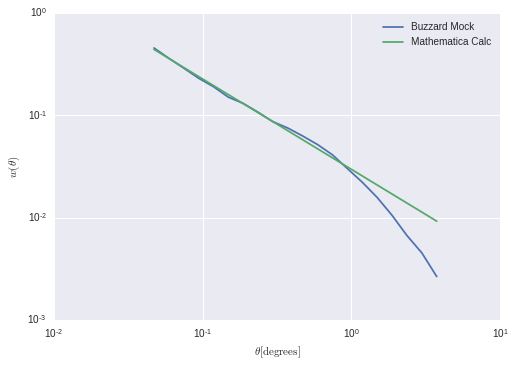

In [109]:
#plt.plot(tpoints_rm, wt, label = 'My Calculation')
plt.plot(tpoints_rm, wt_redmagic, label = 'Buzzard Mock')
plt.plot(tpoints_rm, wt_analytic(-1.88359, 2.22353827e+03,tpoints_rm, x.to("Mpc").value), label = 'Mathematica Calc')

plt.ylabel(r'$w(\theta)$')
plt.xlabel(r'$\theta \mathrm{[degrees]}$')
plt.loglog();
plt.legend(loc='best')

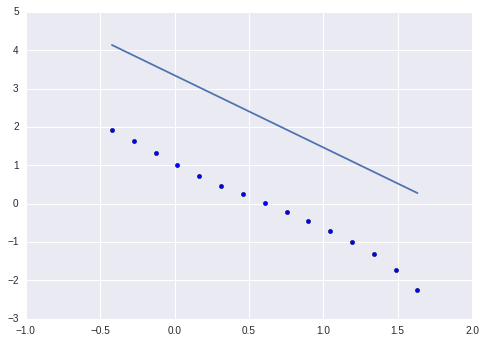

In [111]:
plt.plot(np.log10(rpoints), np.log10(2.22353827e+03)+(np.log10(rpoints)*(-1.88)))
plt.scatter(np.log10(rpoints), np.log10(xi) )


In [ ]:
np.array([v for v in params.values()])